In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style='ticks')
sns.set_theme(style="whitegrid")

from g2aero.Grassmann import *
from g2aero.perturbation import PGAspace, Dataset

plot_folder = os.path.join(os.getcwd(), 'plots_pga_space', )
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

In [2]:
shapes_folder  = os.path.join(os.getcwd(), '../../data/cst_airfoils/', )
airfoils = ['NACA64_A17', 'DU21_A17', 'DU25_A17', 'DU30_A17', 'DU35_A17', 'DU40_A17', 'DU00-W2-350', 'DU08-W-210',
            'FFA-W3-211',  'FFA-W3-241', 'FFA-W3-270blend', 'FFA-W3-301', 'FFA-W3-330blend', 'FFA-W3-360', 'SNL-FFA-W3-500',
            ]
fam = ['NACA', 'DU', 'DU', 'DU', 'DU', 'DU','DU', 
      'FFA',  'FFA', 'FFA', 'FFA', 'FFA', 'FFA', 'FFA']
gap_size = [0.0, 0.003878, 0.004262, 0.00492, 0.00566, 0.00694,  0.01,
            0.00131, 0.00751, 0.01265, 0.0182, 0.024079999999999997, 0.01368, 0.020200000000000003]

families = [f for f in fam for i in range(1001)]
classes = [c for c in airfoils for i in range(1001)]
gap = np.array([g for g in gap_size for i in range(1001)])

n_airfoils = len(airfoils)
label_dict = dict(zip(airfoils, np.arange(n_airfoils)))
files = [shapes_folder + f'{af}.npz'for af in airfoils]
n_landmarks = 401
shapes = np.empty((0, n_landmarks, 2))
for i, file in enumerate(files):
    one_file_shapes = np.load(file)['shapes']
    shapes = np.vstack((shapes, one_file_shapes))
print(shapes.shape)   

# dict_color = {airfoils[i] : colors_pallete[i] for i in range(n_airfoils)}
# colors = np.array([dict_color[airfoil] for airfoil in airfoils for i in range(1001)])
# handles = [Line2D([0], [0], color='w', markerfacecolor=colors_pallete[i], marker='o', markersize=10, 
#                   label=airfoils[i]) for i in range(n_airfoils)]

(14014, 401, 2)


In [23]:
data = Dataset(shapes, method='SPD')
pga, t = PGAspace.create_from_dataset(shapes, method='SPD')

Karcher mean convergence:
||V||_F = 0.05901984126776754
||V||_F = 1.132212418227275e-05
||V||_F = 4.122374605212297e-09


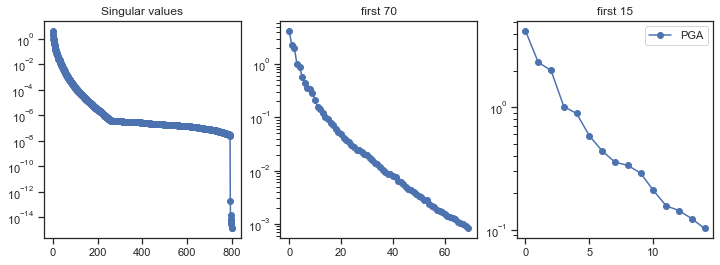

In [24]:
fig, ax = plt.subplots(1, 3,  figsize=(12, 4))
ax[0].semilogy(pga.S, 'o-', label='PGA')
ax[1].semilogy(pga.S[:70], 'o-', label='PGA')
ax[2].semilogy(pga.S[:15], 'o-', label='PGA')
ax[0].set_title('Singular values')
ax[1].set_title('first 70')
ax[2].set_title('first 15')
plt.legend()

Text(0.5, 1.0, 'Grassamnn err')

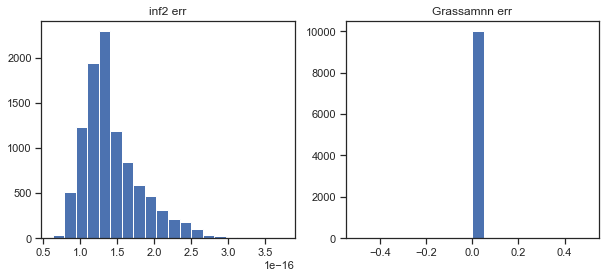

In [25]:
def norm_inf2(sh1, sh2):
    d = np.max(np.linalg.norm(sh1-sh2, ord=2, axis=1))
    return d

# check Exp(Log)
err = []
gr_err= []
for i in range(10000):
    kn = np.random.choice(data.n_shapes, size=2, replace=False)
    X = data.shapes_gr[kn[0]]
    Y = data.shapes_gr[kn[1]]
    direction = log(X, Y)
    new_Y = exp(1, X, direction)
    R = procrustes(new_Y, Y)
    new_Y = new_Y @ R
    err.append(norm_inf2(Y,new_Y))
    gr_err.append(distance(Y, new_Y))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(err, bins=20)
ax[0].set_title('inf2 err')
ax[1].hist(gr_err, bins=20)
ax[1].set_title('Grassamnn err')

In [44]:
r_arr = np.arange(2, 802)
err_gr = np.zeros((data.n_shapes, len(r_arr)))
err_inf2 = np.zeros((data.n_shapes, len(r_arr)))
for i, r in enumerate(r_arr):
    Vh_tmp = pga.Vh[:r]
    for j, coord in enumerate(t[:, :r]): 
        shape_new = perturb_gr_shape(Vh_tmp, pga.karcher_mean, coord)
        R = procrustes(shape_new, data.shapes_gr[j])
        shape_new = shape_new @ R
        err_gr[j, i] = distance(shape_new, data.shapes_gr[j])
        phys_shape = shape_new @ data.M[j] + data.b[j]
        err_inf2[j, i] = norm_inf2(phys_shape, shapes[j])
#         plt.plot(phys_shape[:, 0], phys_shape[:, 1] )
#         plt.plot(shapes[ind[j]][:, 0], shapes[ind[j]][:, 1])

Text(0.5, 0, 'PGA modes')

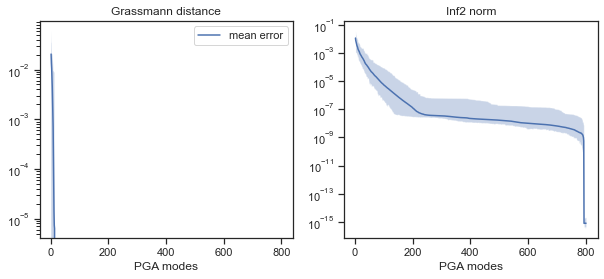

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].semilogy(r_arr, np.mean(err_gr, axis=0), label='mean error')
ax[0].fill_between(r_arr, np.min(err_gr, axis=0), np.max(err_gr, axis=0), alpha=0.3)
ax[0].set_title('Grassmann distance')
ax[0].set_xlabel('PGA modes')
ax[0].legend()
ax[1].semilogy(r_arr, np.mean(err_inf2, axis=0), label='mean error')
ax[1].fill_between(r_arr, np.min(err_inf2, axis=0), np.max(err_inf2, axis=0), alpha=0.3)
ax[1].set_title('Inf2 norm')
ax[1].set_xlabel('PGA modes')

Text(0.5, 0, 'PGA modes')

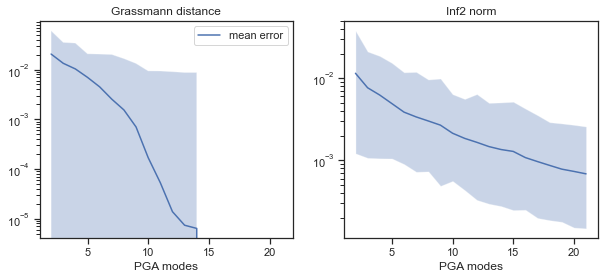

In [47]:
n =20
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].semilogy(r_arr[:n], np.mean(err_gr, axis=0)[:n], label='mean error')
ax[0].fill_between(r_arr[:n], np.min(err_gr, axis=0)[:n], np.max(err_gr, axis=0)[:n], alpha=0.3)
ax[0].set_title('Grassmann distance')
ax[0].set_xlabel('PGA modes')
ax[0].legend()
ax[1].semilogy(r_arr[:n], np.mean(err_inf2, axis=0)[:n], label='mean error')
ax[1].fill_between(r_arr[:n], np.min(err_inf2, axis=0)[:n], np.max(err_inf2, axis=0)[:n], alpha=0.3)
ax[1].set_title('Inf2 norm')
ax[1].set_xlabel('PGA modes')

In [14]:
data = Dataset(shapes)
pga, t = PGAspace.create_from_dataset(shapes, n_modes=4)

Karcher mean convergence:
||V||_F = 0.0590198412677676
||V||_F = 1.1322124182245888e-05
||V||_F = 4.122374604604262e-09


<IPython.core.display.Javascript object>


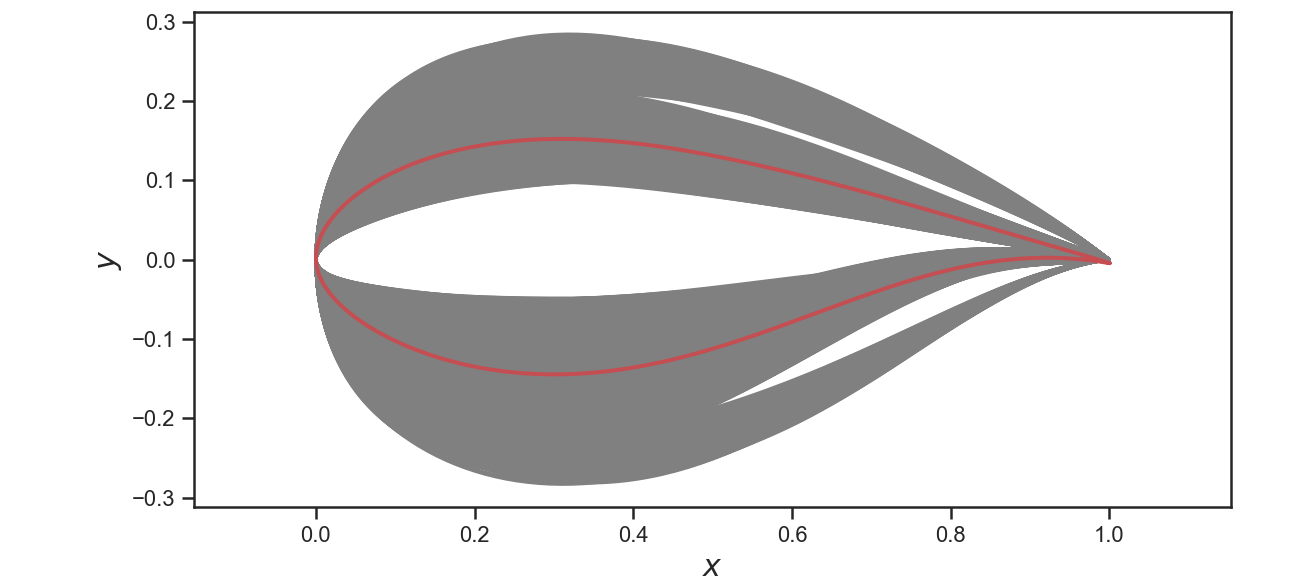

<IPython.core.display.Javascript object>


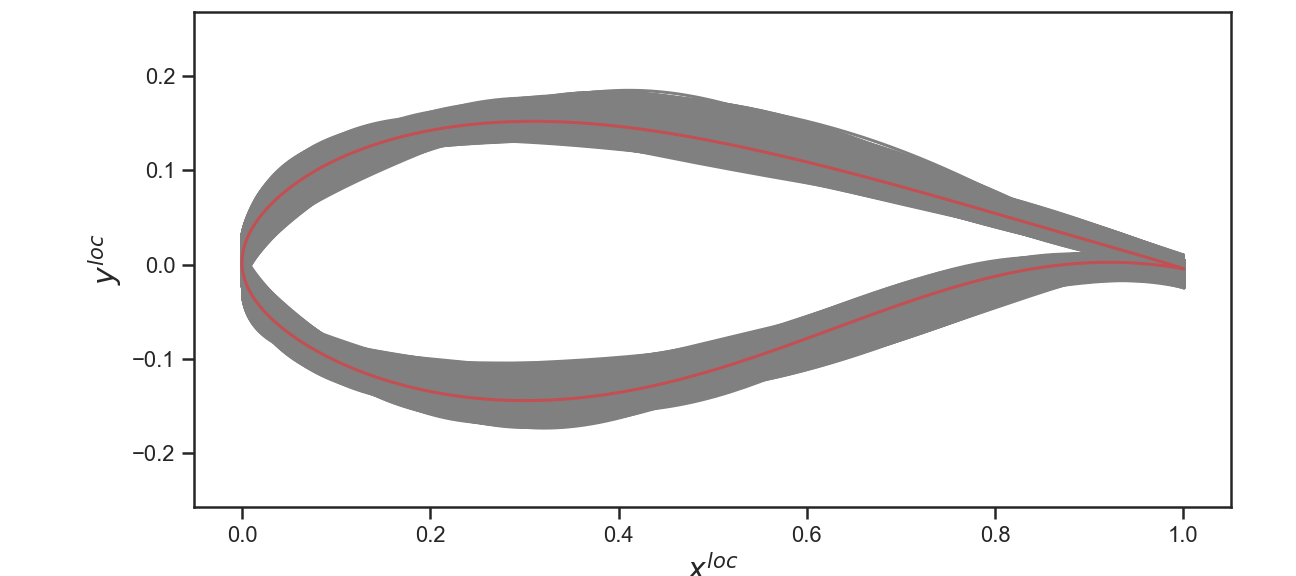

In [12]:
ph_shapes = data.shapes_gr @ pga.M_mean.T + pga.b_mean
karcher_mean_phys = pga.karcher_mean @ pga.M_mean.T + pga.b_mean

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, xy in enumerate(shapes):
    ax.plot(xy[:, 0], xy[:, 1], color='grey')
ax.axis('equal')
ax.plot(karcher_mean_phys[:, 0], karcher_mean_phys[:, 1], color='r', linewidth='2')
ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$y$', fontsize=15)
fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98)
fig.savefig(os.path.join(plot_folder, 'dataset1.png'))

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, xy in enumerate(ph_shapes):
    ax.plot(xy[:, 0], xy[:, 1], color='grey')
ax.axis('equal')
ax.plot(karcher_mean_phys[:, 0], karcher_mean_phys[:, 1], color='r')
ax.set_xlabel(r'$x^{loc}$', fontsize=15)
ax.set_ylabel(r'$y^{loc}$', fontsize=15)
fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98)
fig.savefig(os.path.join(plot_folder, 'dataset.png'))

(15015, 4)


<IPython.core.display.Javascript object>


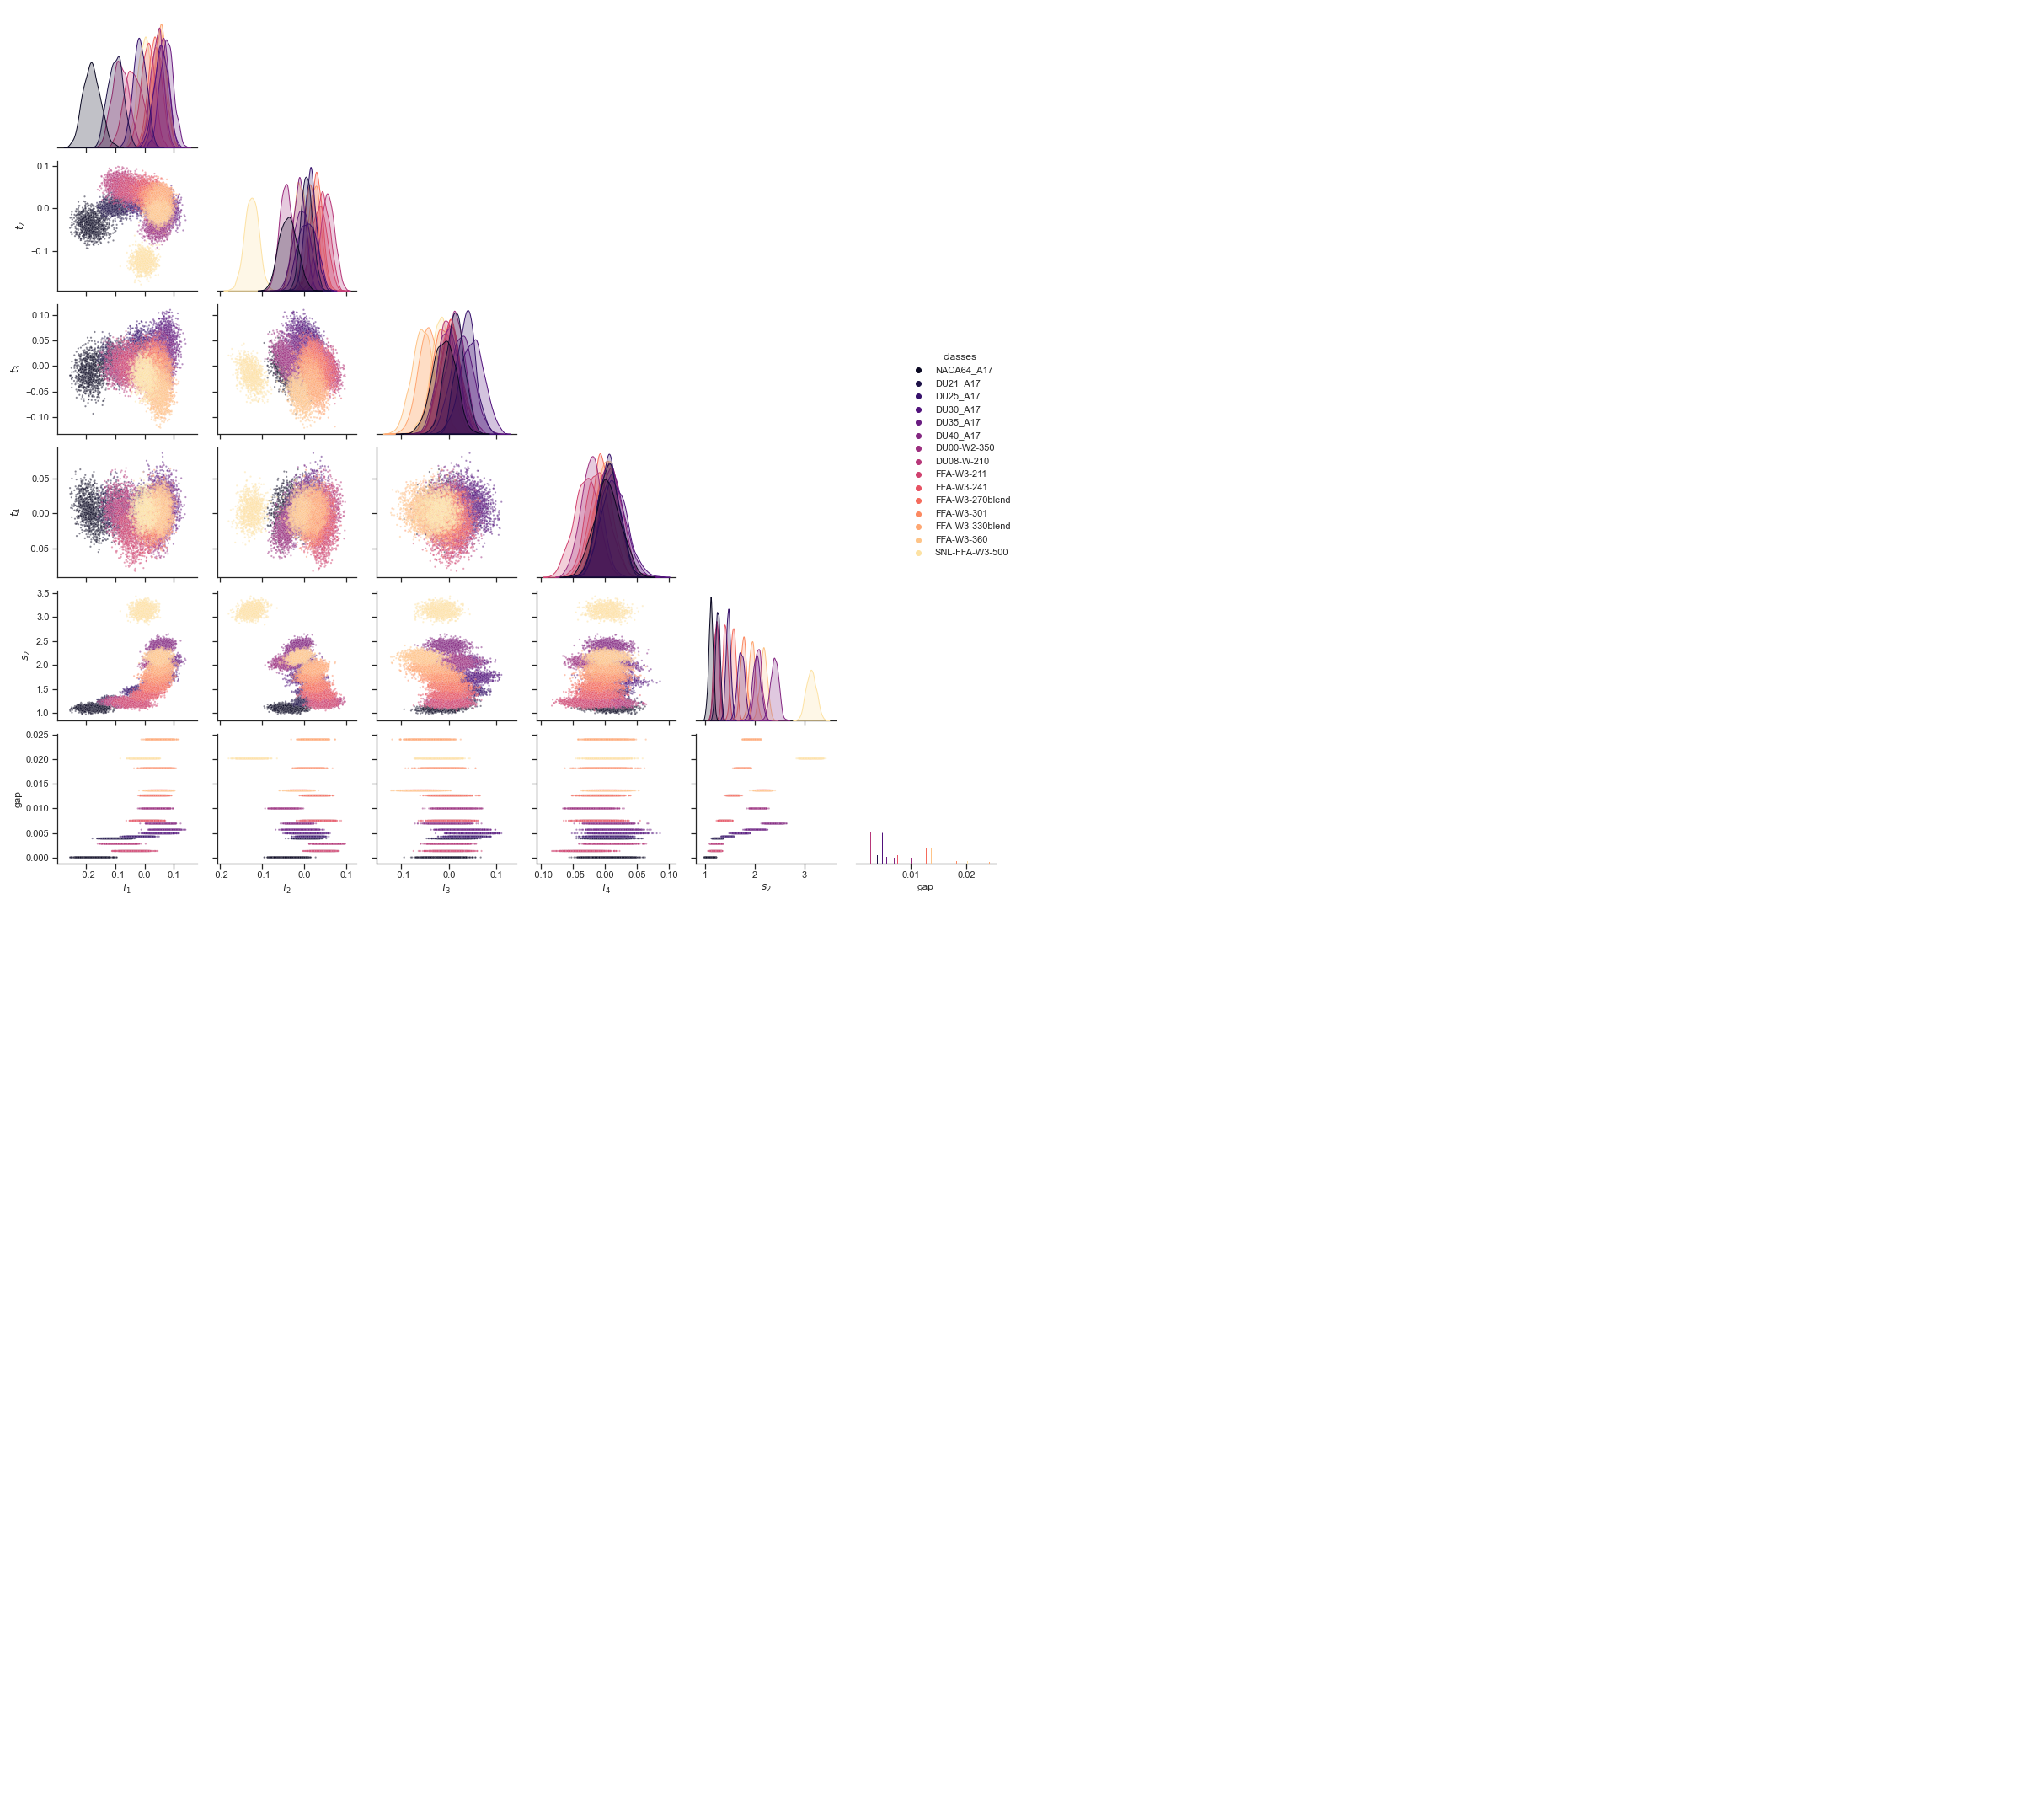

In [5]:
coord = np.hstack((t, data.M[:, 1:, 1], gap.reshape(-1, 1)))
print(t.shape)
df = pd.DataFrame(data=coord, columns=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'])
df.insert(5, "classes", classes)
df.insert(6, "families", families)
sns_plot = sns.pairplot(df, hue="classes",
                        x_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        y_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        diag_kind='kde', palette="magma", corner=True, plot_kws=dict(alpha=.5, s=5))
sns_plot.savefig(os.path.join(plot_folder, 'scatter_classes.png'))

In [1]:
sns_plot = sns.pairplot(df, hue="families",
                        x_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        y_vars=[r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$', r'$s_2$', 'gap'],
                        diag_kind='kde', palette="magma", corner=True)
sns_plot.savefig(os.path.join(plot_folder, 'scatter_families.png'))

NameError: name 'sns' is not defined

In [7]:
fig = px.scatter_3d(df, x=r'$t_1$', y=r'$t_2$', z=r'$t_3$', color="families")
fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
fig.show()
fig.write_html(os.path.join(plot_folder, '3d_families.html'))

In [8]:
np.savez(os.path.join(os.getcwd(), 'PGA_space.npz'), Vh=pga.Vh, M_mean=pga.M_mean, b_mean=pga.b_mean, karcher_mean=pga.karcher_mean)
np.savez(os.path.join(os.getcwd(), 'M_b.npz'), M=data.M, b=data.b)
np.savez(os.path.join(os.getcwd(), 't.npz'), t=t)

In [9]:
# labels1 = ['DU00-W2-350', 'DU97-W-300', 'DU91-W2-250', 'DU08-W-210']
# labels2 = ['DU35_A17', 'DU30_A17', 'DU25_A17', 'DU21_A17']
# %matplotlib notebook
# shapes_folder  = os.path.join(os.getcwd(), '../../../shape_data/dataset/', )
# files1 = [shapes_folder + f'{af}.npy'for af in labels1]
# files2 = [shapes_folder + f'{af}.npy'for af in labels2]
# shapes1 = np.empty((4, 401, 2))
# shapes2 = np.empty((4, 401, 2))
# for i in range(4):
#     shapes1[i] = np.load(files1[i])[0]
#     shapes2[i] = np.load(files2[i])[0]
# fig, ax = plt.subplots(2, 2, figsize=(12, 9))
# for i, (xy1, xy2) in enumerate(zip(shapes1, shapes2)):
#     ax[i//2, i%2].plot(xy2[:, 0], xy2[:, 1], label=labels2[i])
#     ax[i//2, i%2].plot(xy1[:, 0], xy1[:, 1], label=labels1[i])
#     ax[i//2, i%2].axis('equal')
#     ax[i//2, i%2].legend(loc=0)
#     ax[1, i%2].set_xlabel(r'$x^{loc}$', fontsize=15)
#     ax[i//2, 0].set_ylabel(r'$y^{loc}$', fontsize=15)
# fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98, )
# fig.savefig(os.path.join(plot_folder, 'DU_compare.pdf'))

In [10]:
labels1 = ['DU00-W2-350', 'DU97-W-300', 'DU91-W2-250', 'DU08-W-210']
labels2 = ['DU35_A17', 'DU30_A17', 'DU25_A17', 'DU21_A17']
%matplotlib notebook
shapes_folder  = os.path.join(os.getcwd(), '../../../shape_data/dataset/', )
files1 = [shapes_folder + f'{af}.npy'for af in labels1]
files2 = [shapes_folder + f'{af}.npy'for af in labels2]
shapes1 = np.empty((4, 401, 2))
shapes2 = np.empty((4, 401, 2))
for i in range(4):
    shapes1[i] = np.load(files1[i])[0]
    shapes2[i] = np.load(files2[i])[0]
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
for i, (xy1, xy2) in enumerate(zip(shapes1, shapes2)):
    ax[i//2, i%2].plot(xy2[:, 0], xy2[:, 1], label=labels2[i])
    ax[i//2, i%2].plot(xy1[:, 0], xy1[:, 1], label=labels1[i])
    ax[i//2, i%2].axis('equal')
    ax[i//2, i%2].legend(loc=0)
    ax[1, i%2].set_xlabel(r'$x^{loc}$', fontsize=15)
    ax[i//2, 0].set_ylabel(r'$y^{loc}$', fontsize=15)
fig.subplots_adjust(left=0.15, right=0.95,  bottom=0.12, top=0.98, )
fig.savefig(os.path.join(plot_folder, 'DU_compare.pdf'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/odoronin/ARPA-e/notebooks/sweeps/../../../shape_data/dataset/DU00-W2-350.npy'